<h1 style="text-align:center">Vehicle Analysis</h1>

# Library Imports and Style Configuration

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import catppuccin
plt.style.use(catppuccin.PALETTE.latte.identifier)
%matplotlib inline

# Data Loading

In [2]:
df = pd.read_csv("colorado_motor_vehicle_sales.csv")

# Data Exploration

In [3]:
df.head()

,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


In [4]:
df.shape

(501, 4)

## Sales Summary

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Convert sales to millions
sales_million = df['sales'] / 1e6

print("=== Sales Summary (in Million USD) ===")
print(f"Count          : {sales_million.count():,.0f}")
print(f"Mean           : {sales_million.mean():,.2f} M USD")
print(f"Standard Dev   : {sales_million.std():,.2f} M USD")
print(f"Min            : {sales_million.min():,.2f} M USD")
print(f"25th Percentile: {sales_million.quantile(0.25):,.2f} M USD")
print(f"Median         : {sales_million.median():,.2f} M USD")
print(f"75th Percentile: {sales_million.quantile(0.75):,.2f} M USD")
print(f"IQR            : {(sales_million.quantile(0.75) - sales_million.quantile(0.25)):.2f} M USD")
print(f"Max            : {sales_million.max():,.2f} M USD")
print(f"Skewness       : {skew(sales_million):.2f}")
print(f"Kurtosis       : {kurtosis(sales_million):.2f}")

=== Sales Summary (in Million USD) ===
Count          : 501
Mean           : 176.06 M USD
Standard Dev   : 164.21 M USD
Min            : 6.27 M USD
25th Percentile: 61.48 M USD
Median         : 138.58 M USD
75th Percentile: 224.16 M USD
IQR            : 162.68 M USD
Max            : 916.91 M USD
Skewness       : 1.78
Kurtosis       : 3.68


**Convert year and quarter into datetime**

In [6]:
df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" + (((df["quarter"] - 1) * 3) + 1).astype(str) + "-01"
)

# Sales Duration per County

In [7]:
sales_duration_df = pd.DataFrame({
    "Start Year": df.groupby("county")["year"].min().sort_index(),
    "End Year": df.groupby("county")["year"].max().sort_index()
})

In [8]:
sales_duration_df["Duration"] = (sales_duration_df["End Year"] - sales_duration_df["Start Year"]) + 1

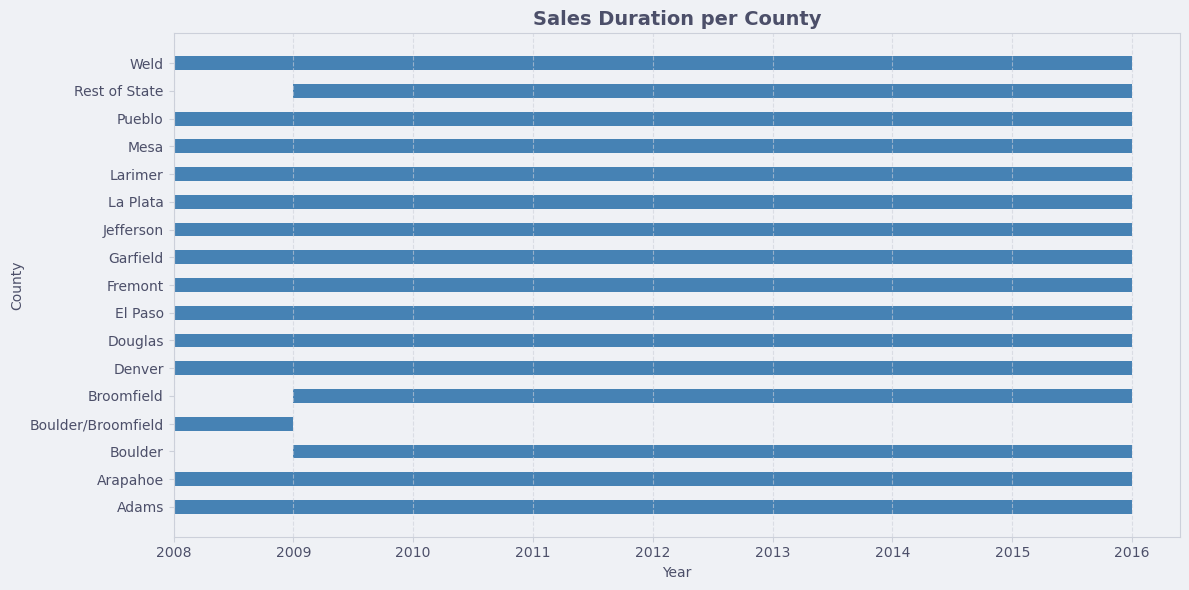

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot bars from start year with width as duration
for i, (county, row) in enumerate(sales_duration_df.iterrows()):
    plt.barh(
        y=county,
        width=row["Duration"],
        left=row["Start Year"],
        height=0.5,
        color="#4682B4",
    )

plt.xlabel("Year")
plt.ylabel("County")
plt.title("Sales Duration per County", fontsize=14, weight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Note: The graph illustrates a change in data categorization. Boulder and Broomfield data were  <br>
combined as "Boulder/Broomfield" in 2008, then reported as separate entities  <br>
from 2009 onwards.

# Number of Entries by County

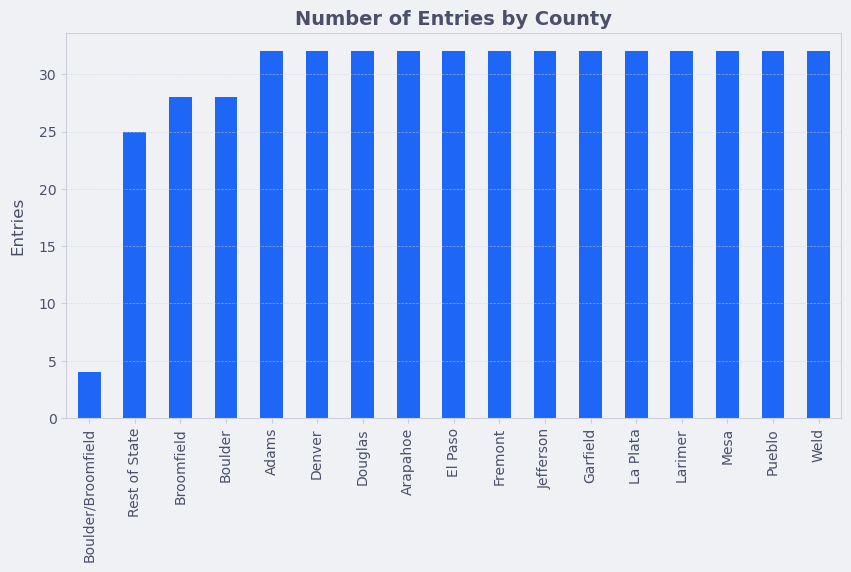

In [10]:
plt.figure(figsize=(10, 5))
df.groupby("county").size().sort_values().plot(kind="bar")
plt.title("Number of Entries by County", fontsize=14, weight="bold")
plt.xlabel("")
plt.ylabel("Entries", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()

# Box plot of Sales Data

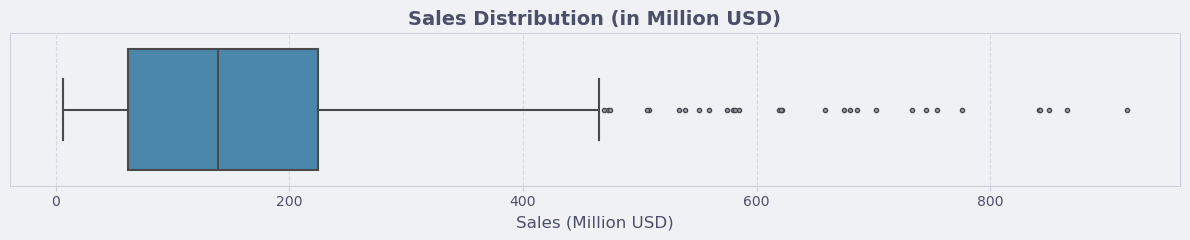

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 2.5))
sns.boxplot(x=df["sales"] / 1e6, color="#3b8bba", linewidth=1.5, fliersize=3)

plt.title("Sales Distribution (in Million USD)", fontsize=14, weight="bold")
plt.xlabel("Sales (Million USD)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks([])
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Beyond the end of the right whisker, these are outliers, representing sales figures <br>
that are significantly higher than the vast majority of the other sales data

# County-wise Quarter Sales

In [12]:
s = df["sales"]
q1 = s.quantile(0.25)
q2 = s.quantile(0.5)
q3 = s.quantile(0.75)
iqr = q3 - q1
lower_whisker = s[s >= q1 - 1.5 * iqr].min()
upper_whisker = s[s <= q3 + 1.5 * iqr].max()

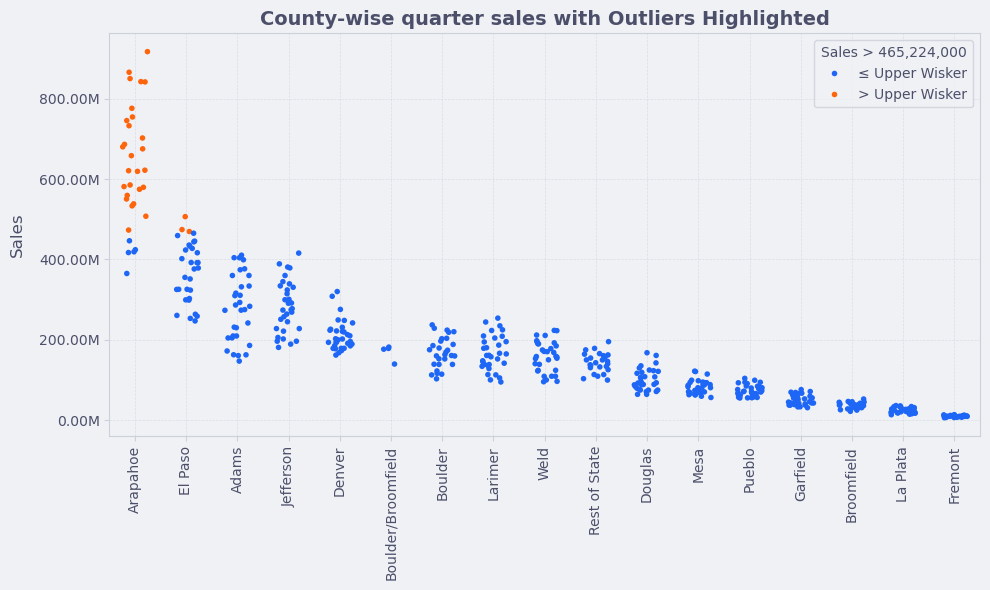

In [13]:
# Defensive: Check if 'sales' and 'county' exist
required_columns = {"county", "sales"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"DataFrame must contain columns: {required_columns}")

# Create boolean column for conditional coloring
df["above_upper_whisker"] = df["sales"] > upper_whisker

# Sort counties by median sales for cleaner x-axis ordering (optional)
ordered_counties = (
    df.groupby("county")["sales"].median().sort_values(ascending=False).index
)

# Strip plot with color highlighting
plt.figure(figsize=(10, 6))
ax = sns.stripplot(
    x="county",
    y="sales",
    data=df,
    hue="above_upper_whisker",
    order=ordered_counties,
    jitter=0.25,
    size=4,
    dodge=False,
)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1e6:,.2f}M"))

# Plot aesthetics
plt.title(
    "County-wise quarter sales with Outliers Highlighted", fontsize=14, weight="bold"
)
plt.xlabel("")
plt.ylabel("Sales", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=["≤ Upper Wisker", "> Upper Wisker"],
    title=f"Sales > {upper_whisker:,.0f}",
    loc="upper right",
)

plt.tight_layout()
plt.show()

# Number of outlier by each county

In [14]:
df[df["above_upper_whisker"]].groupby("county").size()

county
Arapahoe    27
El Paso      3
dtype: int64

# Total Sales by County

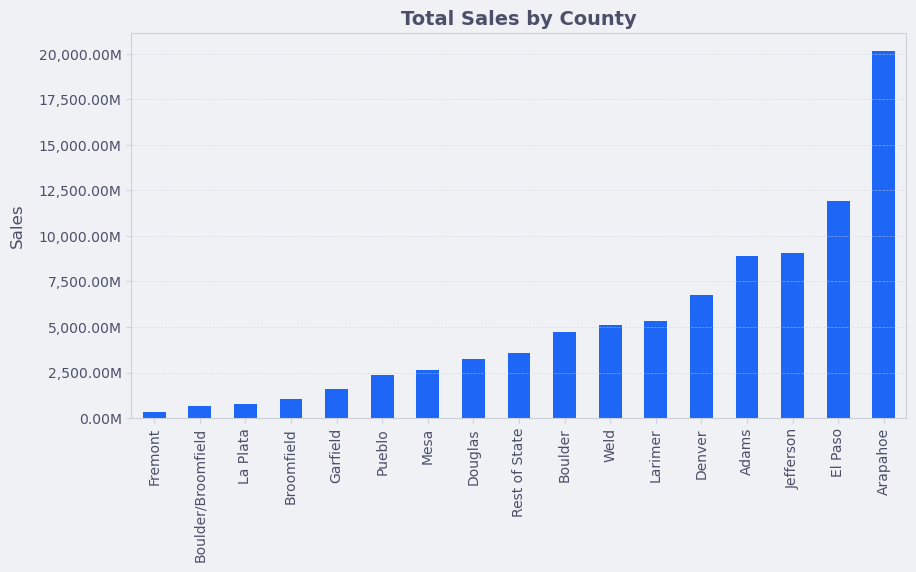

In [15]:
plt.figure(figsize=(10, 5))
ax = df.groupby("county")["sales"].sum().sort_values().plot(kind="bar")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1e6:,.2f}M"))
plt.title("Total Sales by County", fontsize=14, weight="bold")
plt.xlabel("")
plt.ylabel("Sales", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()

# Quarterly Sales by Year

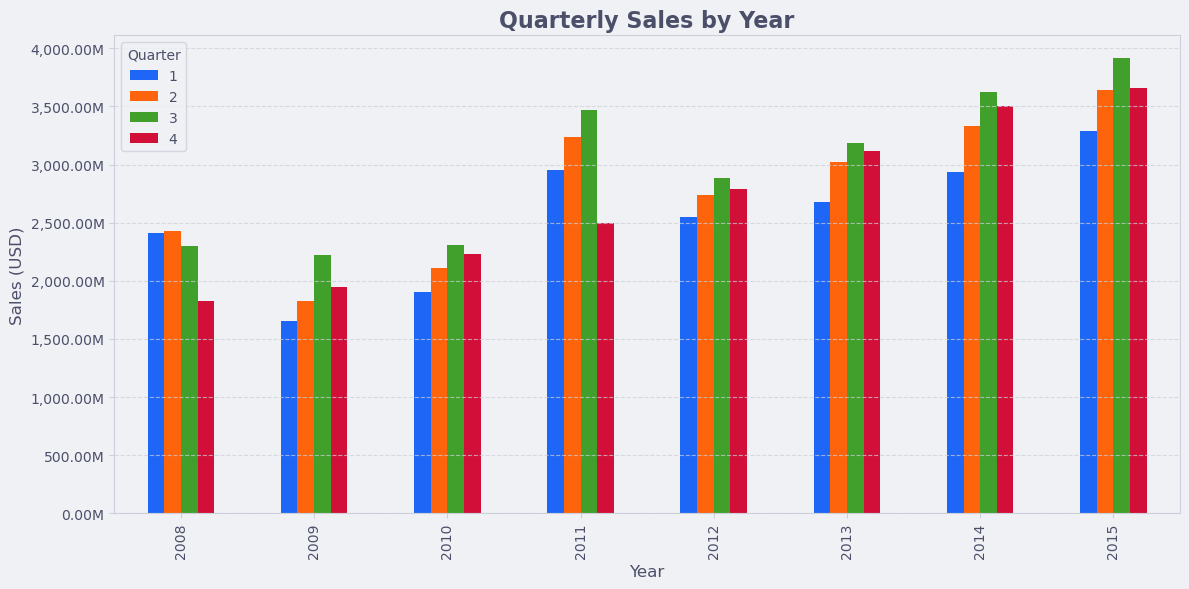

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Clean column names if needed
df.columns = df.columns.str.strip()

# Step 1: Group by year and quarter, and sum the sales
quarterly_sales = df.groupby(["year", "quarter"])["sales"].sum().reset_index()

# Step 2: Pivot for plotting (years as index, quarters as columns)
pivot_table = quarterly_sales.pivot(index="year", columns="quarter", values="sales")

# Step 3: Plot
ax = pivot_table.plot(kind="bar", figsize=(12, 6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1e6:,.2f}M"))

# Optional Formatting
plt.title("Quarterly Sales by Year", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Sales (USD)", fontsize=12)
plt.legend(title="Quarter")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Quarterly Sales by County

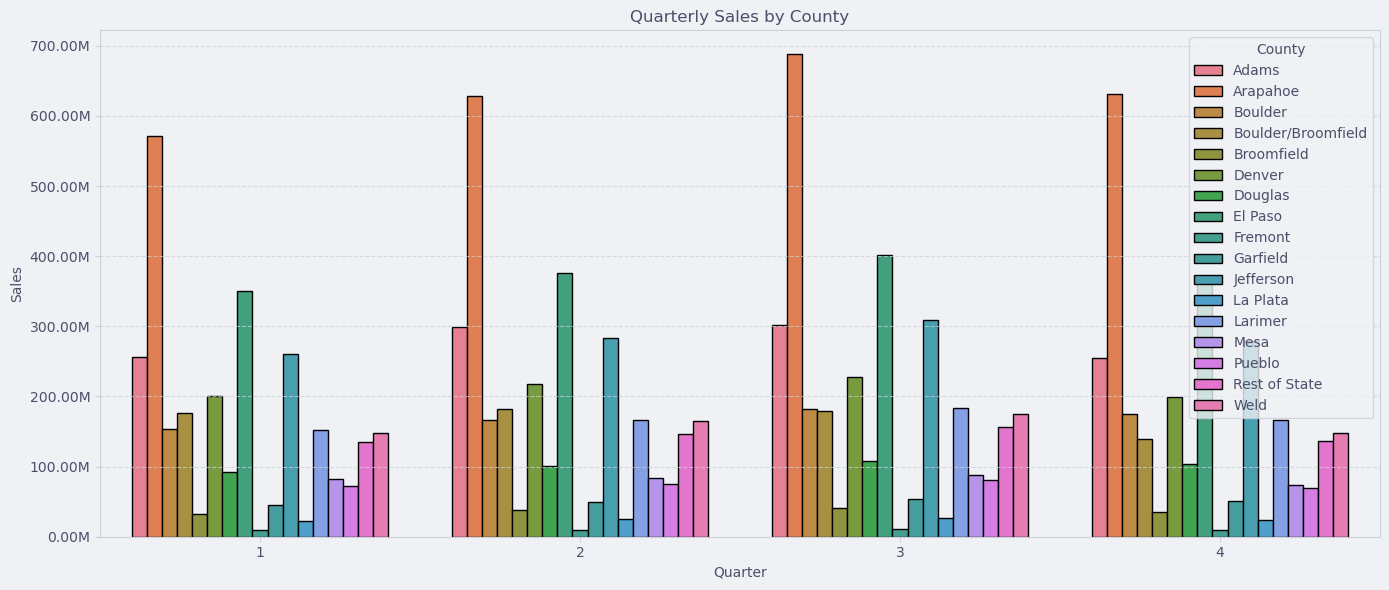

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

quarterly_sales = df.groupby(["county", "year", "quarter"])["sales"].sum().reset_index()

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=quarterly_sales,
    x="quarter",
    y="sales",
    hue="county",
    errorbar=None,
    edgecolor="black",
)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1e6:,.2f}M"))
plt.title("Quarterly Sales by County")
plt.ylabel("Sales")
plt.xlabel("Quarter")
plt.legend(title="County")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Yearly Sales by County

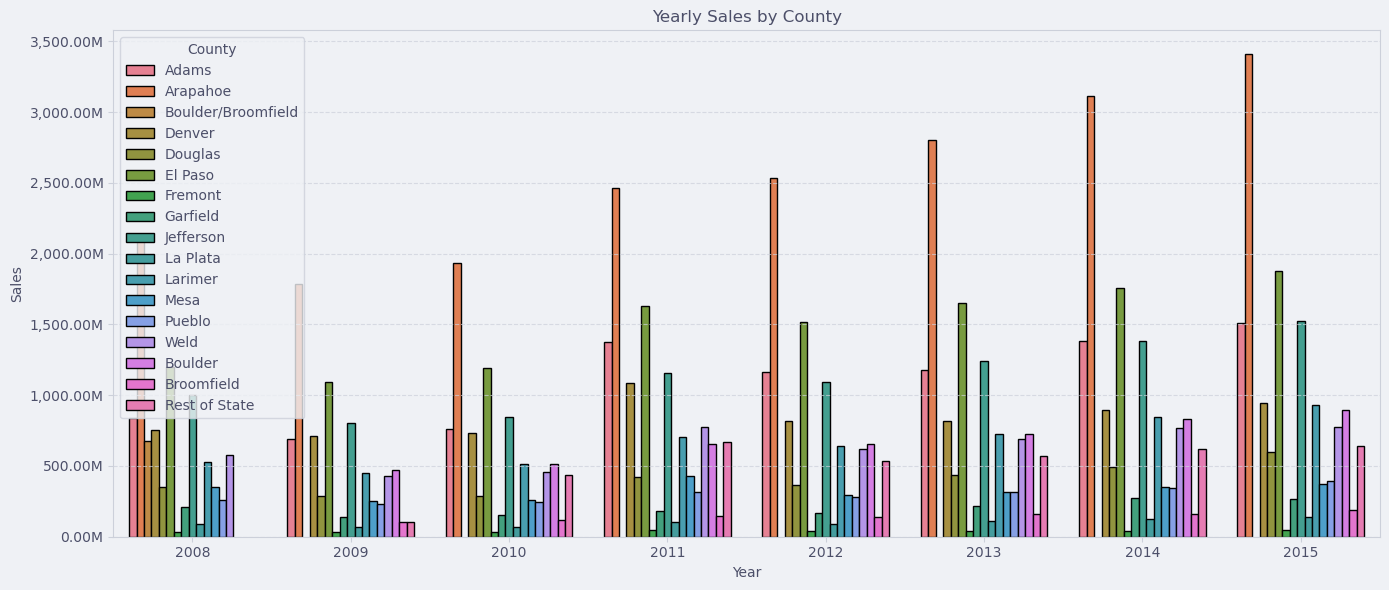

In [18]:
yearly_sales = df.groupby(["county", "year"])["sales"].sum().reset_index()

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=yearly_sales,
    x="year",
    y="sales",
    hue="county",
    errorbar=None,
    edgecolor="black",
)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1e6:,.2f}M"))
plt.title("Yearly Sales by County")
plt.ylabel("Sales")
plt.xlabel("Year")
plt.legend(title="County")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Quarterly Sales for Top 5 Counties

In [19]:
top5_counties = (
    df.groupby("county")["sales"].max().sort_values(ascending=False).head(5).index
)

In [20]:
df_top5 = df[df["county"].isin(top5_counties)].copy()
df_top5["year_quarter"] = df_top5["year"].astype(str) + "-Q" + df_top5["quarter"].astype(str)

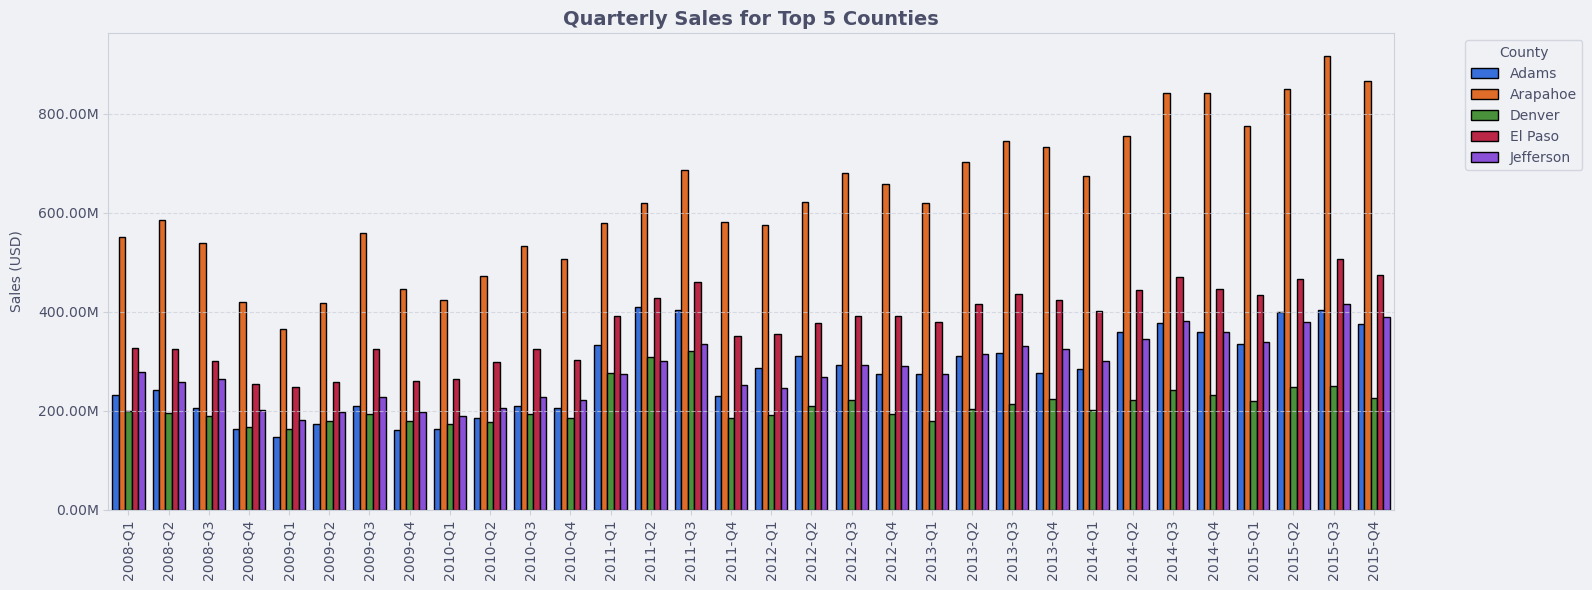

In [21]:
grouped = df_top5.groupby(["year_quarter", "county"])["sales"].sum().reset_index()

plt.figure(figsize=(16, 6))
ax = sns.barplot(
    data=grouped,
    x="year_quarter",
    y="sales",
    hue="county",
    errorbar=None,
    edgecolor="black",
)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1e6:,.2f}M"))
plt.title("Quarterly Sales for Top 5 Counties", fontsize=14, weight="bold")
plt.xlabel("")
plt.ylabel("Sales (USD)", labelpad=10)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="County", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Quarterly Sales Trend

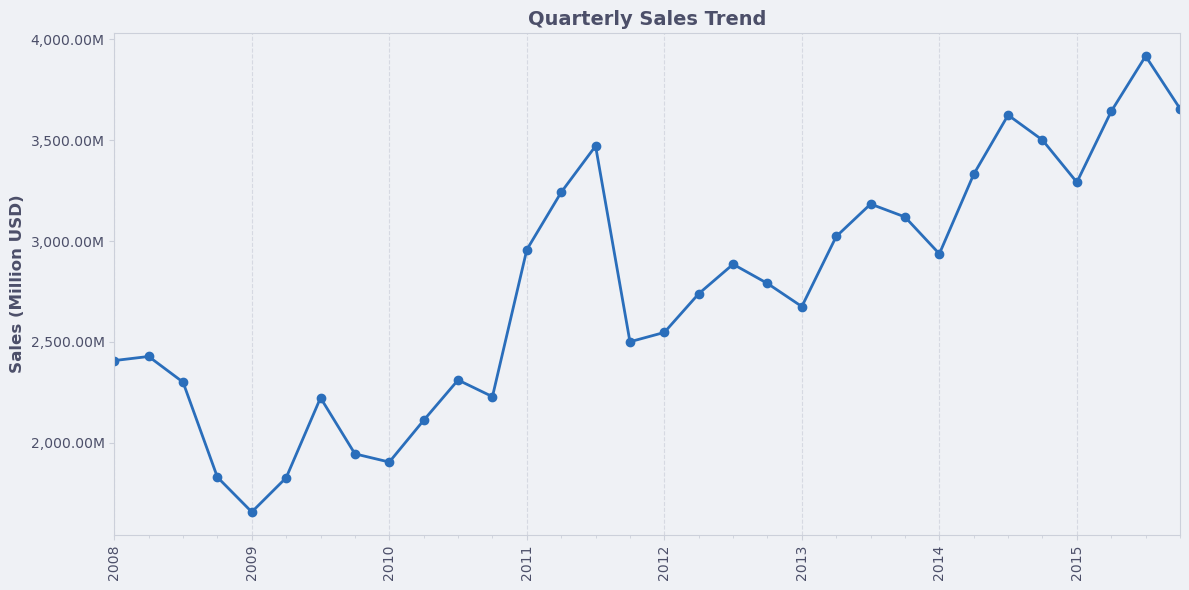

In [22]:
# Set datetime index and aggregate quarterly sales
quarterly_sales = df.set_index("date").resample("QS")["sales"].sum()

# Plot configuration
fig, ax = plt.subplots(figsize=(12, 6))
quarterly_sales.plot(ax=ax, color="#2a6ebb", linewidth=2, marker="o")

# Format Y-axis to millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1e6:,.2f}M"))

# Improve X-axis formatting
ax.set_xlabel("")  # No redundant label
ax.set_ylabel("Sales (Million USD)", fontsize=12, weight="bold")
ax.set_title("Quarterly Sales Trend", fontsize=14, weight="bold")
ax.grid(axis="x", linestyle="--", alpha=0.7)
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

# Variance and Standard Deviation Over Time

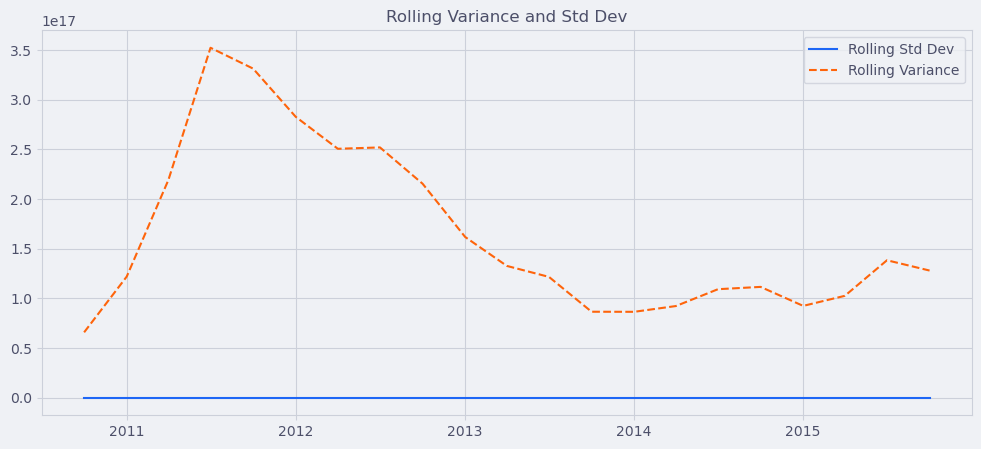

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

rolling_window = 12

rolling_std = quarterly_sales.rolling(window=rolling_window).std()
rolling_var = quarterly_sales.rolling(window=rolling_window).var()

plt.figure(figsize=(12, 5))
plt.plot(rolling_std, label='Rolling Std Dev')
plt.plot(rolling_var, label='Rolling Variance', linestyle='--')
plt.title('Rolling Variance and Std Dev')
plt.legend()
plt.grid(True)
plt.show()


# Seasonal Decomposition

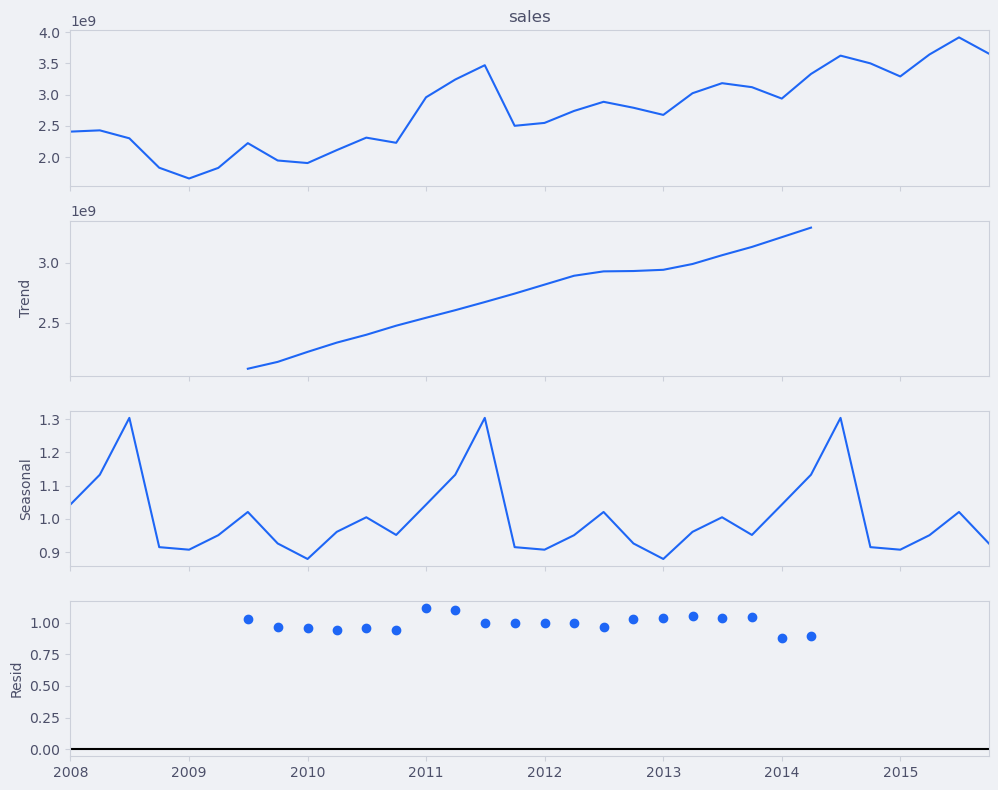

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(quarterly_sales, model='multiplicative', period=12)
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# ML Model

In [25]:
train_size = int(len(quarterly_sales) * 0.80)

train_sales = quarterly_sales.iloc[:train_size]
test_sales  = quarterly_sales.iloc[train_size:]

print("Train shape:", train_sales.shape)
print("Test shape: ", test_sales.shape)

Train shape: (25,)
Test shape:  (7,)


In [26]:
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")
model = SARIMAX(train_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2803      0.967      0.290      0.772      -1.615       2.176
ma.L1         -0.4609      0.827     -0.557      0.577      -2.082       1.160
ar.S.L12      -0.1159      3.134     -0.037      0.970      -6.258       6.026
ma.S.L12       0.4511      3.003      0.150      0.881      -5.435       6.337
sigma2       1.05e+17        nan        nan        nan         nan         nan


In [27]:
forecast = results.get_forecast(steps=len(test_sales))
pred = forecast.predicted_mean
conf_df = forecast.conf_int()

pd.concat(
    [
        pred.rename("Forecast"),
        conf_df.iloc[:, 0].rename("Lower CI"),
        conf_df.iloc[:, 1].rename("Upper CI"),
    ],
    axis=1,
).head()

,Forecast,Lower CI,Upper CI
2014-04-01,3.319736e+09,2.683201e+09,3.956272e+09
2014-07-01,3.685671e+09,2.862756e+09,4.508587e+09
2014-10-01,2.614287e+09,1.656892e+09,3.571683e+09
2015-01-01,2.754239e+09,1.683138e+09,3.825341e+09
2015-04-01,2.931517e+09,1.758707e+09,4.104327e+09


# Forecast vs Actual

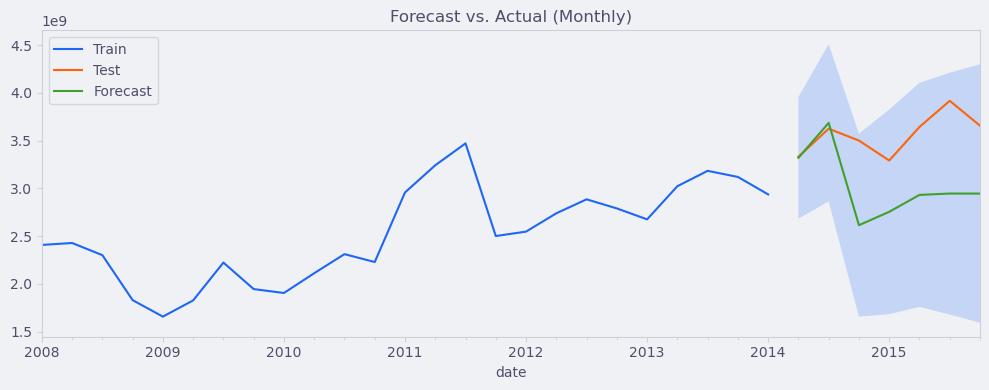

In [28]:
plt.figure(figsize=(10, 4))
train_sales.plot(label="Train")
test_sales.plot(label="Test")
pred.plot(label="Forecast")
plt.fill_between(
    test_sales.index,
    conf_df.iloc[:, 0].astype(float),
    conf_df.iloc[:, 1].astype(float),
    alpha=0.2,
)
plt.legend()
plt.title("Forecast vs. Actual (Monthly)")
plt.tight_layout()
# plt.savefig("images/Montly Sales Forecast.png")
plt.show()

# Forecast Accuracy Metrics

In [29]:
# Compute Accuracy Metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_sales, pred)
rmse = np.sqrt(mean_squared_error(test_sales, pred))
mape = np.mean(np.abs((test_sales - pred) / test_sales)) * 100

metrics = pd.DataFrame({"MAE": [mae], "RMSE": [rmse], "MAPE": [mape]})
metrics

,MAE,RMSE,MAPE
0,5.555505e+08,6.580729e+08,15.346031


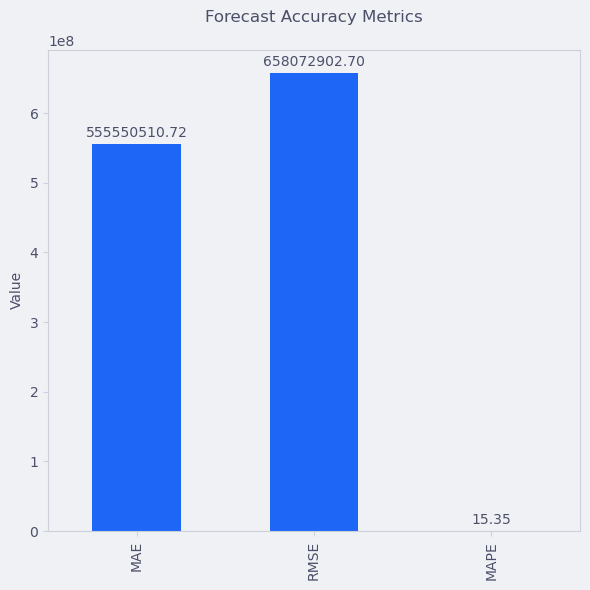

In [30]:
import matplotlib.pyplot as plt

# Bar Chart of Accuracy Metrics with Labels
plt.figure(figsize=(6, 6))
ax = metrics.iloc[0].plot(kind="bar")

plt.title("Forecast Accuracy Metrics", pad=20)
plt.ylabel("Value")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()

# Forecast Accuracy by Model

                                   MAE          RMSE       MAPE
Model                                                          
AR(1)                     8.730147e+08  9.096694e+08  24.173899
MA(1)                     1.019478e+09  1.043220e+09  28.336291
ARMA(1,1)                 9.161603e+08  9.508537e+08  25.389576
ARIMA(1,1,1)              6.334686e+08  6.637395e+08  17.510653
SARIMA(1,1,1)x(1,1,1,12)  5.555505e+08  6.580729e+08  15.346031



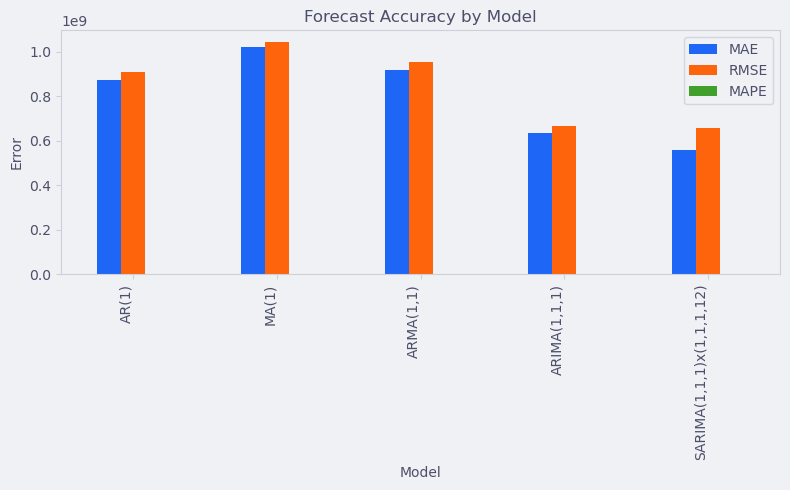


                                   MAE          RMSE       MAPE
Model                                                          
AR(1)                     8.730147e+08  9.096694e+08  24.173899
MA(1)                     1.019478e+09  1.043220e+09  28.336291
ARMA(1,1)                 9.161603e+08  9.508537e+08  25.389576
ARIMA(1,1,1)              6.334686e+08  6.637395e+08  17.510653
SARIMA(1,1,1)x(1,1,1,12)  5.555505e+08  6.580729e+08  15.346031



In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define & fit models (no disp arg)
models = {
    "AR(1)": ARIMA(train_sales, order=(1, 0, 0)).fit(),
    "MA(1)": ARIMA(train_sales, order=(0, 0, 1)).fit(),
    "ARMA(1,1)": ARIMA(train_sales, order=(1, 0, 1)).fit(),
    "ARIMA(1,1,1)": ARIMA(train_sales, order=(1, 1, 1)).fit(),
    "SARIMA(1,1,1)x(1,1,1,12)": SARIMAX(
        train_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
    ).fit(),
}

# Forecast with each
results = {}
for name, fitted in models.items():
    if "SARIMA" in name:
        pred = fitted.get_forecast(steps=len(test_sales)).predicted_mean
    else:
        pred = fitted.forecast(steps=len(test_sales))
        pred.index = test_sales.index  # align index
    results[name] = pred

# Compute accuracy metrics
metrics = []
for name, pred in results.items():
    mae = mean_absolute_error(test_sales, pred)
    rmse = np.sqrt(mean_squared_error(test_sales, pred))
    mape = np.mean(np.abs((test_sales - pred) / test_sales)) * 100
    metrics.append({"Model": name, "MAE": mae, "RMSE": rmse, "MAPE": mape})

metrics_df = pd.DataFrame(metrics).set_index("Model")
print(metrics_df)
print()
# Visual comparison
metrics_df.plot(kind="bar", figsize=(8, 5), title="Forecast Accuracy by Model")
plt.ylabel("Error")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()